In [1]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from matplotlib.colors import ListedColormap
import os
from PIL import Image


In [2]:
path_script = os.getcwd()
dir_name = 'pngs'
os.mkdir(os.path.join(path_script, dir_name))
rs = np.random.RandomState(seed=1097)

In [3]:
class NeighborhoodType(Enum):
    CROSS = "+"
    NEUMAN = "x"
class CellState(Enum):
    EMPTY = 0
    FIRING = 1
    TREE = 2
# Массив из указанных трёх цветов...
colors = ["#49423D", "orange", "green"]
# и сама цветовая карта
cmap_forest = ListedColormap(colors)
class CellColor(Enum):
    EMPTY = colors[0]
    FIRING = colors[1]
    TREE = colors[2]

In [4]:
def plot_grid(ca, t, ax=None, **kw):
    if ax is None:
        fig, ax = plt.subplots(figsize = (15,15))
    ax.matshow(ca, cmap=cmap_forest)
    nh = kw.get("nh", "")
    time_stamp = kw.get("time_stamp", "")
    ax.set(
        xlabel="Length",
        ylabel="Width",
        title=f'Окрестность:{nh}. Время:{time_stamp}',
        aspect="equal"
    )
    plt.rc('axes', titlesize= 20 )
    fig = ax.get_figure()
    fig.savefig(os.path.join(path_script, dir_name) + f'/{t}.png')

    plt.close()

In [5]:
def create_ca(w, h):
    X = np.zeros((w, h))
    return X

def init_state(ca, eta, f):
    w, h = ca.shape
    num_trees = int(eta * w * h)
    a = ca.flatten()
    tree_indices = rs.choice(a.size, size=num_trees, replace=False)
    a[tree_indices]= CellState.TREE.value
    b = np.argwhere(a == CellState.TREE.value)
    burn_indices = rs.choice(b.size, size=f, replace=False)
    a[burn_indices] = CellState.FIRING.value
    return a.reshape(ca.shape)

In [6]:
def update(grid, neighborhood_type, p_g, p_f):
    """Обновление всего КА."""
    new_grid = np.copy(grid)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            update_cell(grid, new_grid, [i,j], neighborhood_type, p_g, p_f)
    return new_grid

def update_cell(grid, new_grid, cell, neighborhood, p_g, p_f):
    """Обновление состояния заданной клетки `cell`."""
    i,j = cell
    if neighborhood == "+" and grid[i,j] == CellState.TREE.value:
        values = get_cross_neighborhood([i,j],grid)
        if np.any(values == CellState.FIRING.value):
            new_grid[i,j] = CellState.FIRING.value
        else:
            if np.random.random()<p_f:
                new_grid[i,j] = CellState.FIRING.value 
        return
    if neighborhood == "x" and grid[i,j] == CellState.TREE.value:
        values = get_neuman_neighborhood([i,j],grid)
        if np.any(values == CellState.FIRING.value):
            new_grid[i,j] = CellState.FIRING.value
        else:
            if np.random.random()<p_f:
                new_grid[i,j] = CellState.FIRING.value 
        return 
    if grid[i,j] == CellState.TREE.value and np.random.random()<p_f:
        new_grid[i,j] = CellState.FIRING.value
        return
    if grid[i,j] == CellState.FIRING.value:
        new_grid[i,j] = CellState.EMPTY.value
        return
    if grid[i,j] == CellState.EMPTY.value and np.random.random()<p_g:
        new_grid[i,j] = CellState.TREE.value
        return

In [7]:
def get_cross_neighborhood(cell, grid):
    """Крестовая окрестность."""
    i,j = cell
    index_list = [(i - 1,j),
        (i,j-1),
        (i,j+1),
        (i + 1,j)]
    index =[]
    if index_list[0][0] >= 0:
        index.append(index_list[0])
    if index_list[1][1]>= 0:
        index.append(index_list[1])
    if index_list[2][1]<grid.shape[1]:
        index.append(index_list[2])
    if index_list[3][0]<grid.shape[0]:
        index.append(index_list[3])
    values = []
    for i in index:
        values.append(grid[i[0],i[1]])
    return np.array(values, dtype = np.int32)

def get_neuman_neighborhood(cell, grid):
    """Окрестность фон-Неймана."""
    i,j = cell
    index_list = [(i - 1,j - 1),
        (i - 1,j + 1),
        (i + 1,j + 1),
        (i + 1,j - 1),
        (i - 1,j),
        (i,j-1),
        (i,j+1),
        (i + 1,j)]
    index =[]
    if index_list[0][0] >= 0 and index_list[0][1] >= 0:
        index.append(index_list[0])
    if index_list[1][0]>= 0 and index_list[1][1]< grid.shape[1]:
        index.append(index_list[1])
    if index_list[2][0]<grid.shape[0] and index_list[2][1]<grid.shape[1]:
        index.append(index_list[2])
    if index_list[3][0]< grid.shape[0] and index_list[3][1] >= 0:
        index.append(index_list[3])
    if index_list[4][0] >= 0:
        index.append(index_list[4])
    if index_list[5][1]>= 0:
        index.append(index_list[5])
    if index_list[6][1]<grid.shape[1]:
        index.append(index_list[6])
    if index_list[7][0]<grid.shape[0]:
        index.append(index_list[7])
    values = [] 
    for i in index:
        values.append(grid[i[0],i[1]])
    return np.array(values, dtype = np.int32)

In [8]:
class Statistics:
    def __init__(self):
        # Массив шагов по времени
        self.t = []
        # Количество горящих деревьев на временных шагах
        self.a_f = []
        # Количество здоровых деревьев на временных шагах
        self.a_t = []
        # Количество пустых клеток на временных шагах
        self.a_e = []
 
    def append(self, t, ca):
        """Добавить данные КА `ca` в на шаге времени `t`."""
        self.t.append(t)
        self.a_f.append(np.count_nonzero(ca == CellState.FIRING.value))
        self.a_t.append(np.count_nonzero(ca == CellState.TREE.value))
        self.a_e.append(np.count_nonzero(ca == CellState.EMPTY.value))

    def get_a_f(self):
        return self.a_f

    def get_a_t(self):
        return self.a_t
 
    def get_a_e(self):
        return self.a_e
 
    def plots_for_all(self, ax=None, **kw):
        """Графики для горящих, пустых и ячеек с деревьями"""
        fig, ax = plt.subplots(figsize = (15,8))
        plt.rc('axes', titlesize= 20)
        nh = kw.get("nh", "")
        pf = kw.get("pf", "")
        ax.set(
            xlabel="Время t",
            ylabel="Количество N",
            title=f'Окрестность:{nh}. $P_f$ = {pf}'
        )
        ax.plot(self.t, self.a_f, label= 'Горящие деревья')
        ax.plot(self.t, self.a_t, label= 'Деревья')
        ax.plot(self.t, self.a_e, label= 'Пустые клетки')
        plt.legend()
        plt.grid()
        return ax

In [9]:
def simulate(ca: np.ndarray,
            nt: NeighborhoodType,
            time: int):
    """Смоделировать процесс лесного пожара.
    * `ca` - матрица начального состояния КА.
    * `nt` - тип окрестности.
    * `time` - число шагов моделирования по времени
    (время моделирования).
    """
    st = Statistics()
    for t in range(time):
        ca = update(ca, nt, p_g, p_f)
        plot_grid(ca,t, nh = 'x', time_stamp = t)
        st.append(t, ca)
    return st

166.2651706040685

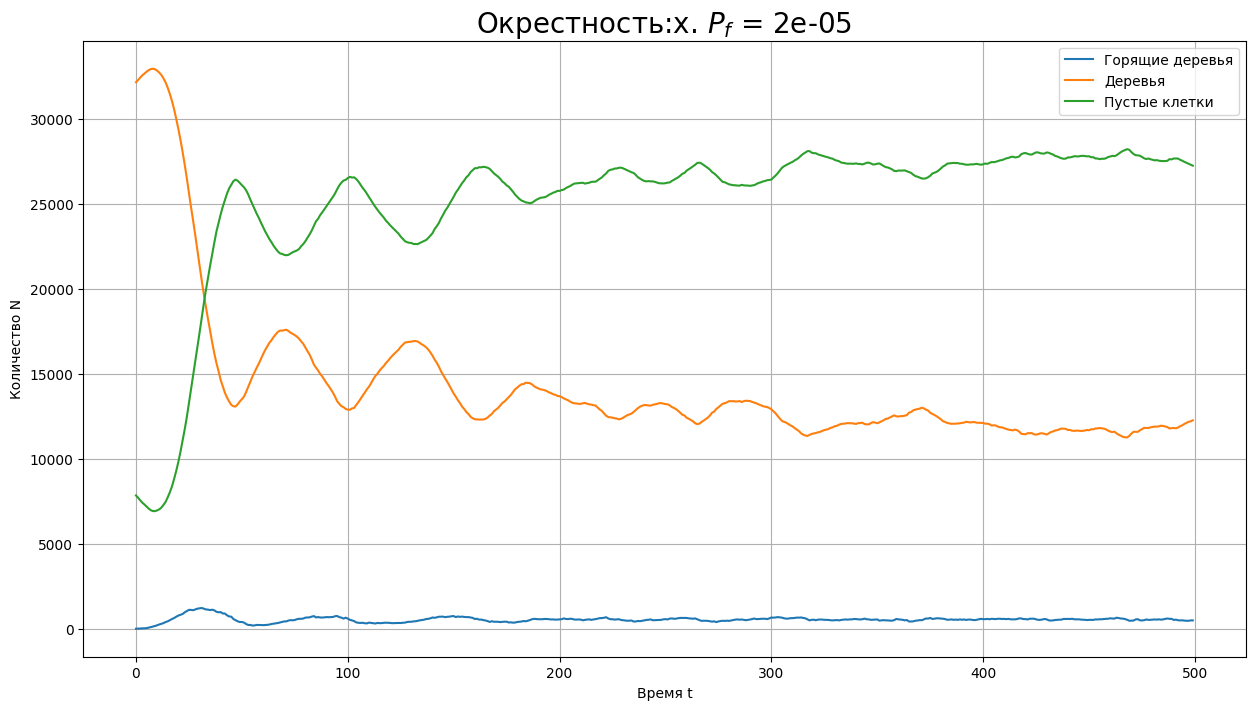

In [10]:
# "Затравка" для генератора псевдослучайных чисел
seed = 1097
# Размеры клеточного поля
w, h = 200, 200
# Доля клеток с деревьями
eta = 0.8
# Число изначально горящих деревьев
f = 1
# Вероятность вырастания нового дерева
p_g = 0.02
# Вероятность случайного воспламенения дерева
p_f = 2e-5
# Модельное время (число обновлений автомата)
sim_time = 500

ca = create_ca(w, h)
ca = init_state(ca, eta, f)
initial_ca = np.copy(ca)
stat = simulate(ca, "x", sim_time)
stat.plots_for_all(nh = 'x', pf = p_f)
frames = []

for frame_number in range(1, sim_time):
    frame = Image.open(os.path.join(path_script, dir_name) + f'/{frame_number}.png')
    frames.append(frame)
frames[0].save(
    'forest.gif',
    save_all=True,
    append_images=frames[1:],
    optimize=True,
    duration=100,
    loop=0
)
a_f = np.asarray(stat.get_a_f())
a_f.mean()
np.std(a_f)